Importing necessary libraries

In [47]:
from collections import Counter
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [51]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv("spam.csv", encoding="latin-1")  # Adjust encoding if needed


In [5]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

In [6]:
df['label'] = LabelEncoder().fit_transform(df['label'])

Text Preprocessing

In [31]:
df.duplicated().values.any()

True

In [32]:
df.duplicated().sum()

403

In [33]:
df.drop_duplicates(inplace=True)

In [34]:
df.describe()

,label
count,5169.000000
mean,0.126330
std,0.332253
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [35]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]  # Stemming
    return ' '.join(words)

In [36]:
df['cleaned_message'] = df['message'].apply(preprocess_text)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_message']).toarray()
y = df['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training models

In [10]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [11]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")


Logistic Regression Performance:
Accuracy: 0.95
Precision: 0.96
Recall: 0.64
F1 Score: 0.77

Random Forest Performance:
Accuracy: 0.98
Precision: 1.00
Recall: 0.83
F1 Score: 0.91

Gradient Boosting Performance:
Accuracy: 0.97
Precision: 0.99
Recall: 0.75
F1 Score: 0.85


In [12]:
param_grid = {
    'n_estimators': [100, 200],  # Reduce options
    'max_depth': [10, 20],       # Reduce depth values
    'min_samples_split': [2, 5]  # Reduce split values
}


In [13]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Evaluating best model

In [37]:
y_pred_rf = best_rf.predict(X_test)
print("\nBest Random Forest Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")


Best Random Forest Model Performance:
Accuracy: 0.94
Precision: 1.00
Recall: 0.54
F1 Score: 0.70


**`Visualizations `**

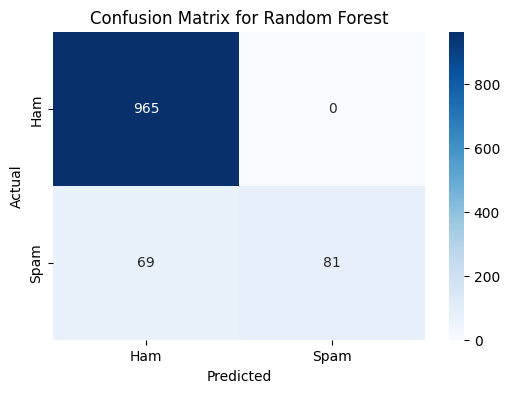

In [38]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

<ipython-input-52-ed2865eb10d5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spam_df['Word'], y=spam_df['Count'], palette='Reds_r')


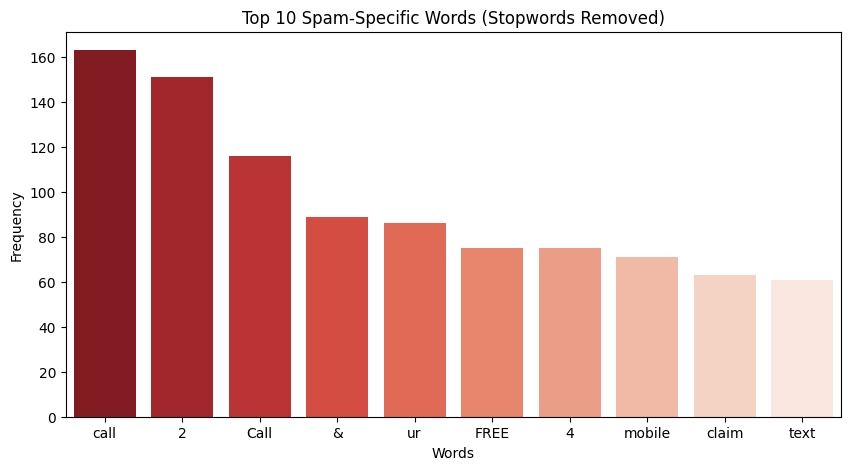

In [52]:
spam_words = " ".join(df[df['label'] == 1]['message']).split()
spam_words = [word for word in spam_words if word.lower() not in stop_words]

# Count word frequencies
spam_word_freq = Counter(spam_words).most_common(10)

# Convert to DataFrame
spam_df = pd.DataFrame(spam_word_freq, columns=['Word', 'Count'])

# Plot bar chart
plt.figure(figsize=(10,5))
sns.barplot(x=spam_df['Word'], y=spam_df['Count'], palette='Reds_r')
plt.title('Top 10 Spam-Specific Words (Stopwords Removed)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

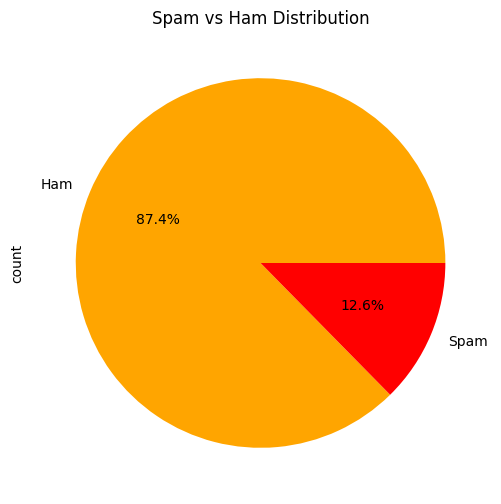

In [59]:
plt.figure(figsize=(6,6))
df['label'].value_counts().plot.pie(autopct="%1.1f%%", colors=["orange", "red"], labels=["Ham", "Spam"])
plt.title("Spam vs Ham Distribution")
plt.show()

Predicting new messages

In [43]:
def predict_spam(message):
    cleaned_message = preprocess_text(message)
    vectorized_message = vectorizer.transform([cleaned_message]).toarray()
    prediction = best_rf.predict(vectorized_message)
    return "Spam" if prediction[0] == 1  else "Ham"

In [44]:
new_message = "Hey, How are you "
print("\nTest Message Prediction:", predict_spam(new_message))


Test Message Prediction: Ham
